In [25]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

In [3]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/
path = get_file('cat', BASE_PATH + 'cat.bin')

In [5]:
def load_icons(path, train_size=0.85):
    x = []
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white')
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]
                draw.line(points, fill=0, width=2)
            img = img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)


x_train, x_test = load_icons(path)
x_train.shape, x_test.shape

((104721, 32, 32, 1), (18481, 32, 32, 1))

In [15]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)

    x = Dense(channels)(x)

    for i in range(4):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

32
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_100 (Conv2D)              (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_101 (Conv2D)              (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_37 (Concatenate)     (None, 32, 32, 8)     0                                            
________________________________________________________________________________________

In [16]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 104721 samples, validate on 18481 samples
Epoch 1/100
104721/104721 [==============================] - 8s - loss: 0.4684 - val_loss: 0.4114
Epoch 2/100
104721/104721 [==============================] - 7s - loss: 0.3984 - val_loss: 0.3878
Epoch 3/100
104721/104721 [==============================] - 7s - loss: 0.3782 - val_loss: 0.3742
Epoch 4/100
104721/104721 [==============================] - 7s - loss: 0.3641 - val_loss: 0.3625
Epoch 5/100
104721/104721 [==============================] - 7s - loss: 0.3541 - val_loss: 0.3578
Epoch 6/100
104721/104721 [==============================] - 7s - loss: 0.3463 - val_loss: 0.3517
Epoch 7/100
104721/104721 [==============================] - 7s - loss: 0.3401 - val_loss: 0.3377
Epoch 8/100
104721/104721 [==============================] - 7s - loss: 0.3344 - val_loss: 0.3363
Epoch 9/100
104721/104721 [==============================] - 7s - loss: 0.3297 - val_loss: 0.3362
Epoch 10/100
104721/104721 [==============================] - 7s - 

In [17]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

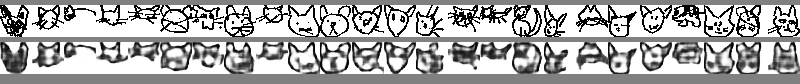

In [18]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [19]:
batch_size = 250
latent_space_depth = 64

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [26]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, num_pixels, 1))
    channels = 4
    x = pixels
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x) 
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear', name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear', name='z_log_var')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    up_samp0 = UpSampling2D((2, 2))
    up_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    up_samp1 = UpSampling2D((2, 2))
    up_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
    up_samp2 = UpSampling2D((2, 2))
    up_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    up_samp3 = UpSampling2D((2, 2))
    up_conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')
    up_samp4 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    decoder_in = Input(shape=(latent_space_depth,))
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    d_x = up_samp0(d_x)
    d_x = up_conv1(d_x)
    d_x = up_samp1(d_x)
    d_x = up_conv2(d_x)
    d_x = up_samp2(d_x)
    d_x = up_conv3(d_x)
    d_x = up_samp3(d_x)
    d_x = up_conv4(d_x)
    d_x = up_samp4(d_x)
    decoder_out= decoded(d_x)

    decoder = Model(decoder_in, decoder_out)    

    a_x = Reshape((1, 1, latent_space_depth))(z)
    a_x = up_samp0(a_x)
    a_x = up_conv1(a_x)
    a_x = up_samp1(a_x)
    a_x = up_conv2(a_x)
    a_x = up_samp2(a_x)
    a_x = up_conv3(a_x)
    a_x = up_samp3(a_x)
    a_x = up_conv4(a_x)
    a_x = up_samp4(a_x)
    outputs= decoded(a_x)
    
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

variational_auto_encoder, variational_decoder = VariationalAutoEncoder(x_train.shape[1])
variational_auto_encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_142 (Conv2D)              (None, 32, 32, 4)     40                                           
____________________________________________________________________________________________________
conv2d_143 (Conv2D)              (None, 32, 32, 4)     20                                           
____________________________________________________________________________________________________
concatenate_53 (Concatenate)     (None, 32, 32, 8)     0                                            
___________________________________________________________________________________________

In [40]:
x_train_2 = x_train[:-(x_train.shape[0] % batch_size),:,: :]
x_test_2 = x_test[:-(x_test.shape[0] % batch_size),:,: :]
x_train_2.shape, x_test_2.shape

((104500, 32, 32, 1), (18250, 32, 32, 1))

In [42]:
variational_auto_encoder.fit(x_train_2, x_train_2, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_2, x_test_2))

Train on 104500 samples, validate on 18250 samples
Epoch 1/100
104500/104500 [==============================] - 4s - loss: 4091.7586 - KL_loss: 0.4836 - reconstruction_loss: 4091.2755 - val_loss: 4094.3999 - val_KL_loss: 0.0189 - val_reconstruction_loss: 4094.3814
Epoch 2/100
104500/104500 [==============================] - 4s - loss: 4090.8811 - KL_loss: 0.0051 - reconstruction_loss: 4090.8764 - val_loss: 4094.2792 - val_KL_loss: 0.0011 - val_reconstruction_loss: 4094.2785
Epoch 3/100
104500/104500 [==============================] - 4s - loss: 4090.8357 - KL_loss: 5.3823e-04 - reconstruction_loss: 4090.8356 - val_loss: 4094.2628 - val_KL_loss: 1.8237e-04 - val_reconstruction_loss: 4094.2631
Epoch 4/100
104500/104500 [==============================] - 3s - loss: 4090.8259 - KL_loss: 8.3614e-05 - reconstruction_loss: 4090.8264 - val_loss: 4094.2574 - val_KL_loss: 4.0133e-05 - val_reconstruction_loss: 4094.2579
Epoch 5/100
104500/104500 [==============================] - 3s - loss: 4090.

104500/104500 [==============================] - 4s - loss: 4090.8166 - KL_loss: 1.1420e-07 - reconstruction_loss: 4090.8171 - val_loss: 4094.2504 - val_KL_loss: 1.9888e-07 - val_reconstruction_loss: 4094.2508
Epoch 74/100
104500/104500 [==============================] - 3s - loss: 4090.8167 - KL_loss: 1.0070e-07 - reconstruction_loss: 4090.8171 - val_loss: 4094.2503 - val_KL_loss: 1.6067e-07 - val_reconstruction_loss: 4094.2508
Epoch 75/100
104500/104500 [==============================] - 3s - loss: 4090.8167 - KL_loss: 8.8314e-08 - reconstruction_loss: 4090.8171 - val_loss: 4094.2504 - val_KL_loss: -2.6192e-08 - val_reconstruction_loss: 4094.2508
Epoch 76/100
104500/104500 [==============================] - 3s - loss: 4090.8166 - KL_loss: 9.2490e-08 - reconstruction_loss: 4090.8171 - val_loss: 4094.2504 - val_KL_loss: 1.6418e-08 - val_reconstruction_loss: 4094.2508
Epoch 77/100
104500/104500 [==============================] - 3s - loss: 4090.8166 - KL_loss: 1.7664e-07 - reconstructio

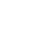

In [50]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(variational_decoder.predict(random_number).reshape(img_width, img_height))


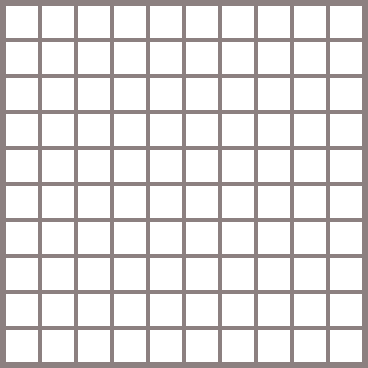

In [51]:
num_cells = 10
img_width = img_height = 32
overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [48]:
decoded.shape

(1, 32, 32, 1)